In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import pandas as pd
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='notebook', style='white', rc={"font.family": "DejaVu Serif"})

# point attractor

In [106]:
a = -10
tau = 0.1
def attractor_dynamics(x):
    x_dot = a * (x - 1)
    return tau * x_dot + x
model = nengo.Network(seed=1)
with model:
    kick = nengo.Node(lambda t: 1 if t<0.01 else 0)
    state = nengo.Ensemble(n_neurons=100, dimensions=1, radius=1,
                           encoders=nengo.dists.Choice([[1]]), intercepts=nengo.dists.Uniform(0.1,1))
    nengo.Connection(state, state, function=attractor_dynamics, synapse=tau)
    nengo.Connection(kick, state, synapse=0.01)
    p = nengo.Probe(state, synapse=0.01)
with nengo.Simulator(model) as sim:
    sim.run(5.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

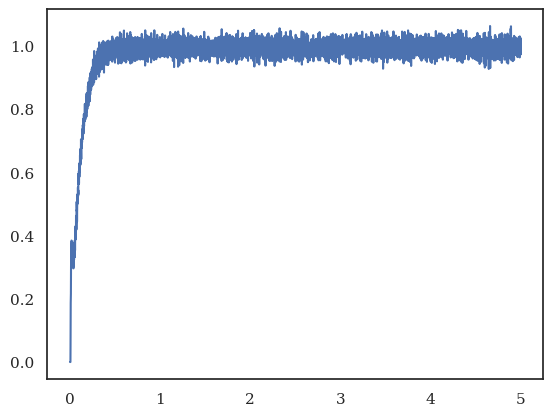

In [107]:
fig, ax = plt.subplots()
ax.plot(sim.trange(), sim.data[p])
plt.show()

## two dimensional

In [126]:
a = -10
d = 10
tau = 0.1
def coupled_attractor(x):
    x1, x2 = x
    dx1 = a * (x1 - 1) - d * x2
    dx2 = a * (x2 - 1) - d * x1
    return [tau * dx1 + x1, tau * dx2 + x2]
model = nengo.Network(seed=1)
with model:
    kick = nengo.Node(lambda t: [1,0] if 1<t<1.01 else [0,0])
    state = nengo.Ensemble(100, 2, encoders=nengo.dists.Choice([[1,0],[0,1]]), intercepts=nengo.dists.Uniform(0.1,1))
    nengo.Connection(state, state, function=coupled_attractor, synapse=tau)
    nengo.Connection(kick, state, synapse=0.01)
    p = nengo.Probe(state, synapse=0.01)
with nengo.Simulator(model) as sim:
    sim.run(5.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

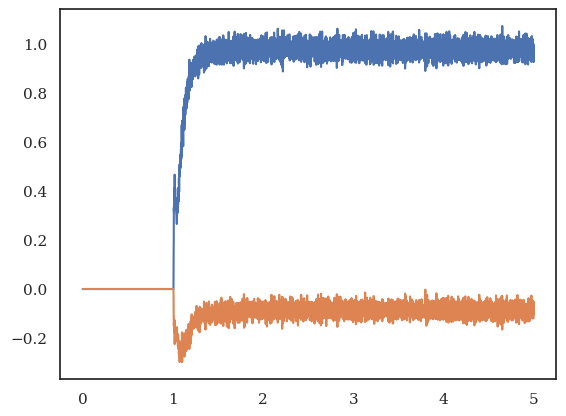

In [127]:
fig, ax = plt.subplots()
ax.plot(sim.trange(), sim.data[p])
plt.show()

# integrator driving point attractor, plus negative feedback from attractor to integrator

In [102]:
value = 0.1
ramp = 1
converge = -100
threshold = 0.5
tau = 0.1
decay = 1.0
neurons = 300
winh = -decay * np.ones((neurons, 1))
def attractor_dynamics(x):
    x_dot = converge * (x - 1)
    return tau * x_dot + x
model = nengo.Network(seed=1)
with model:
    inpt = nengo.Node(value)
    thr = nengo.Node(-threshold)
    action = nengo.Ensemble(neurons, 1)
    choice = nengo.Ensemble(neurons, 1, encoders=nengo.dists.Choice([[1]]), intercepts=nengo.dists.Uniform(0,1))
    nengo.Connection(inpt, action, transform=ramp)
    nengo.Connection(action, action, synapse=tau)
    nengo.Connection(action, choice, synapse=tau)
    nengo.Connection(thr, choice, synapse=tau)
    nengo.Connection(choice, choice, function=attractor_dynamics, synapse=tau)
    nengo.Connection(choice, action.neurons, transform=winh, synapse=tau)
    p_a = nengo.Probe(action, synapse=0.01)
    p_c = nengo.Probe(choice, synapse=0.01)
with nengo.Simulator(model) as sim:
    sim.run(3.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

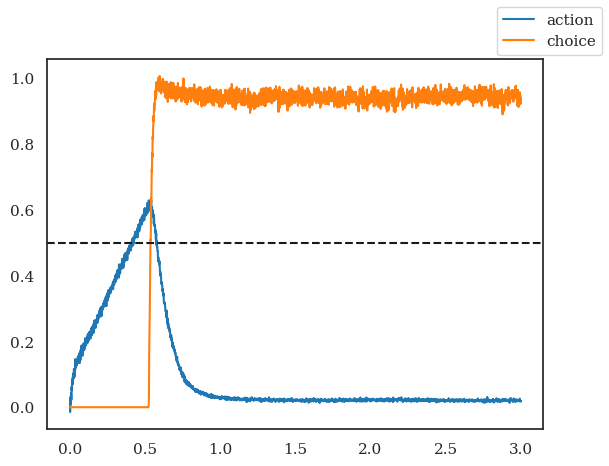

In [103]:
fig, ax = plt.subplots()
ax.plot(sim.trange(), sim.data[p_a], color=palette[0], label='action')
ax.plot(sim.trange(), sim.data[p_c], color=palette[1], label='choice')
ax.axhline(threshold, color='k', ls="--")
fig.legend()
plt.show()

# two dimensional

In [178]:
value = [0.2, 0.19]
ramp = 1
converge = -5
mutual_inhibit = 5
thr = 0.5
tau = 0.1
decay = 2.0
neurons = 300
winh = -decay * np.ones((neurons, 1))
def coupled_attractor(x):
    x1, x2 = x
    dx1 = converge * (x1 - 1) - mutual_inhibit * x2
    dx2 = converge * (x2 - 1) - mutual_inhibit * x1
    return [tau * dx1 + x1, tau * dx2 + x2]
model = nengo.Network(seed=1)
with model:
    inpt = nengo.Node(value)
    threshold = nengo.Node([-thr, -thr])
    action = nengo.Ensemble(neurons, 2)
    choice = nengo.Ensemble(neurons, 2, encoders=nengo.dists.Choice([[1,0], [0,1]]), intercepts=nengo.dists.Uniform(0,1), radius=2)
    nengo.Connection(inpt, action, transform=ramp)
    nengo.Connection(action, action, synapse=tau)
    nengo.Connection(action, choice, synapse=tau)
    nengo.Connection(threshold, choice, synapse=tau)
    nengo.Connection(choice, choice, function=coupled_attractor, synapse=tau)
    nengo.Connection(choice[0], action.neurons, transform=winh, synapse=tau)
    nengo.Connection(choice[1], action.neurons, transform=winh, synapse=tau)
    p_a = nengo.Probe(action, synapse=0.01)
    p_c = nengo.Probe(choice, synapse=0.01)
with nengo.Simulator(model) as sim:
    sim.run(3.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

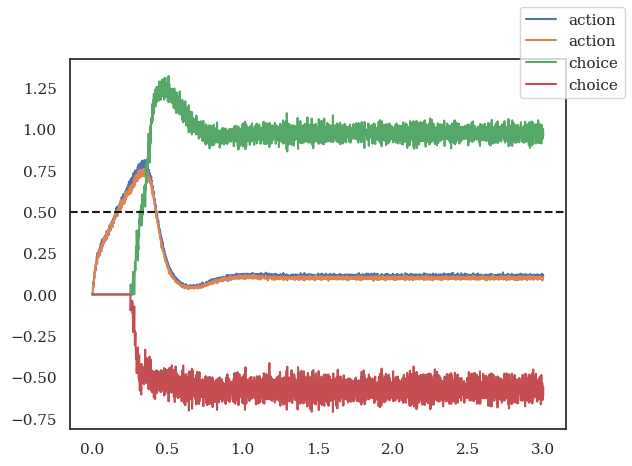

In [179]:
fig, ax = plt.subplots()
ax.plot(sim.trange(), sim.data[p_a], label='action')
ax.plot(sim.trange(), sim.data[p_c], label='choice')
ax.axhline(thr, color='k', ls="--")
fig.legend()
plt.show()

# decaying threshold forces choice

In [249]:
value = [0.2, 0.1]
ramp = 1
converge = -5
mutual_inhibit = 5
thr0 = 0.5
t_end = 1.5
tau = 0.1
decay = 2.0
neurons = 300
winh = -decay * np.ones((neurons, 1))
def coupled_attractor(x):
    x1, x2 = x
    dx1 = converge * (x1 - 1) - mutual_inhibit * x2
    dx2 = converge * (x2 - 1) - mutual_inhibit * x1
    return [tau * dx1 + x1, tau * dx2 + x2]
def thr_decay(t):
    thr = thr0 - thr0*t/t_end
    thr = max([thr,0])
    return [-thr, -thr]
model = nengo.Network(seed=1)
with model:
    inpt = nengo.Node(value)
    threshold = nengo.Node(lambda t: thr_decay(t))
    action = nengo.Ensemble(neurons, 2)
    choice = nengo.Ensemble(neurons, 2, encoders=nengo.dists.Choice([[1,0], [0,1]]), intercepts=nengo.dists.Uniform(0,1))
    nengo.Connection(inpt, action, transform=ramp)
    nengo.Connection(action, action, synapse=tau)
    nengo.Connection(action, choice, synapse=tau)
    nengo.Connection(threshold, choice, synapse=None)
    nengo.Connection(choice, choice, function=coupled_attractor, synapse=tau)
    nengo.Connection(choice[0], action.neurons, transform=winh, synapse=tau)
    nengo.Connection(choice[1], action.neurons, transform=winh, synapse=tau)
    p_a = nengo.Probe(action, synapse=0.01)
    p_c = nengo.Probe(choice, synapse=0.01)
    p_thr = nengo.Probe(threshold[0], synapse=None)
with nengo.Simulator(model) as sim:
    sim.run(t_end)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

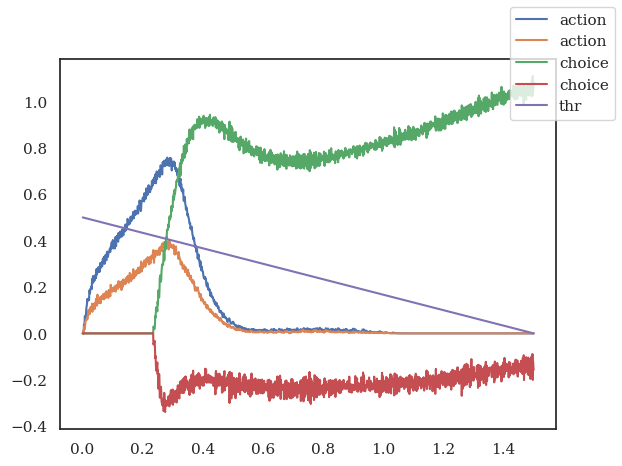

In [250]:
fig, ax = plt.subplots()
ax.plot(sim.trange(), sim.data[p_a], label='action')
ax.plot(sim.trange(), sim.data[p_c], label='choice')
ax.plot(sim.trange(), -sim.data[p_thr], label='thr')
fig.legend()
plt.show()